### Model7 settings:

We combine classes to 2 classes. then we merge 50% of 'half-true' data in class 1 and rest of it in class 2.

We used full preproccess.

We tokenized and used Word2Vec.

We use y_scores for stacking but it wasn't helpfull so we used binary predictions.

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
from sklearn.metrics import precision_recall_fscore_support
import Scripts.Data_Read_Prepare as Data_Prepare
import Scripts.Fake_News_Detection_SVM as SVM_classifier
import Scripts.Fake_News_Detection_PA as PA_classifier
import Scripts.Fake_News_Detection_XGBoost as XGBoost_classifier
import Scripts.Fake_News_Detection_LSTM as LSTM_classifier
import Scripts.Fake_News_Detection_BiLSTM as BiLSTM_classifier
import Scripts.Fake_News_Detection_Stacked_MLP as MLP_classifier

Loading data from datasets

In [2]:
data_train, data_valid, data_test = Data_Prepare.read_data()
data_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


In [3]:
data_train = Data_Prepare.combine_classes_distribute_half_true(data_train)
data_valid = Data_Prepare.combine_classes_distribute_half_true(data_valid)
data_test = Data_Prepare.combine_classes_distribute_half_true(data_test)

c:\users\diba\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
c:\users\diba\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
c:\users\diba\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A va

In [4]:
data_train.head(3)

,label,weight,sentence
0,0,1,abortion dwayne-bohac State representative Tex...
1,0,1,"energy,history,job-accomplishments scott-surov..."
2,1,2,foreign-policy barack-obama President Illinois...


Preproccesing

In [5]:
data_train, data_valid, data_test = Data_Prepare.do_preprocessing(data_train, data_valid, data_test)

data_preprocessing done!


In [5]:
data_train['label'].value_counts(normalize='true')

0    0.552301
1    0.447699
Name: label, dtype: float64

In [6]:
# Combine the training and validation datasets for training
data_set_all = pd.concat([data_train, data_valid, data_test])
data_train_valid = pd.concat([data_train, data_valid])

X_train_valid = data_train_valid['sentence']
y_train_valid = data_train_valid['label']
X_test = data_test['sentence']
y_test = data_test['label']

In [7]:
#plot_data_length(data_set_all)

Vectorizing

In [7]:
embedding_matrix,X_train_t_v, y_train_t_v, X_test_t_v, y_test_t_v, vocab_size = Data_Prepare.tokenize_vectorize(data_set_all, data_train_valid,
                                                                                                                data_test,
                                                                                                               MAX_SEQUENCE_LENGTH=300,
                                                                                                                EMBEDDING_DIM=1500)

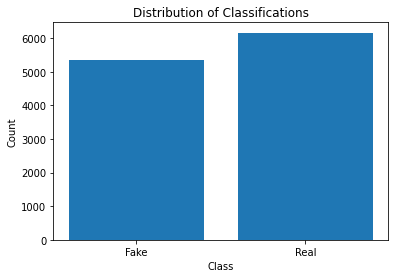

In [8]:
#Visualizing distribution of predeiction of ensemble clas
class_counts = np.bincount(y_train_valid)
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']
plt.xticks(range(len(class_counts)), class_labels)
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## 1- SVM

In [11]:
svm_predictions, svm_train_valid_predictions =SVM_classifier.train_svm(X_train_t_v,
                                                                       y_train_valid, X_test_t_v,
                                                                      0.06,'scale','poly')

Execution time of SVM: 58.39 seconds


In [12]:
#Cross Validation
svm_params = {'C': 0.06, 'kernel': 'poly', 'gamma': 'scale'}
cv_scores_f1, average_f1_score = SVM_classifier.cross_validate_svm(X_train_t_v, y_train_valid,svm_params, cv_splits=5)

NameError: name 'make_scorer' is not defined

SVM - accuracy: 0.5493291239147593
SVM - Precision: 0.5497835497835498
SVM - Recall: 0.9256559766763849
SVM - F-score: 0.6898424769147202


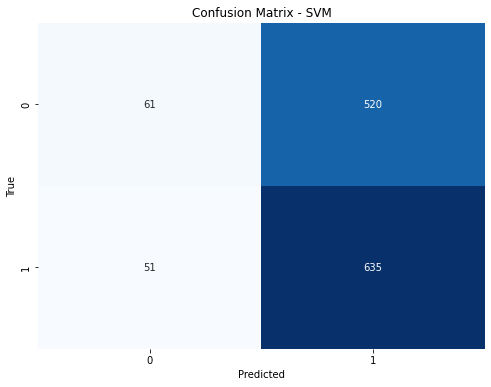

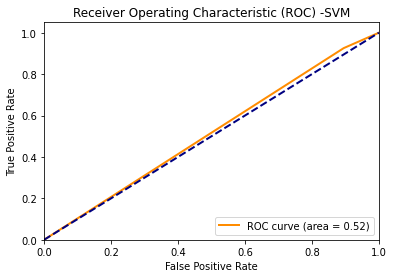

In [13]:
svm_accuracy, svm_precision, svm_recall, svm_fscore = SVM_classifier.svm_metrics(svm_predictions, y_test)
SVM_classifier.svm_confusion_matrix_plot(svm_predictions, y_test)
SVM_classifier.svm_roc_plot(svm_predictions, y_test)

## 2-Passive Aggressive

In [15]:
pa_predictions,pa_train_valid_predictions, pa_scores, pa_train_scores = PA_classifier.train_pa(X_train_t_v, y_train_t_v,
                                                     X_test_t_v, c = 0.01,iteration=500, tol=1e-7)

# pa_predictions,pa_train_valid_predictions,pa_scores = PA_classifier.train_pa(X_train_t_v, y_train_t_v,X_test_t_v)

Execution time of PA: 0.17 seconds


PA - accuracy: 0.526440410418311
PA - Precision: 0.5442386831275721
PA - Recall: 0.7711370262390671
PA - F-score: 0.638118214716526


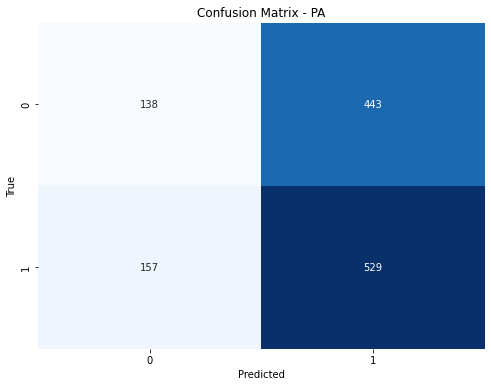

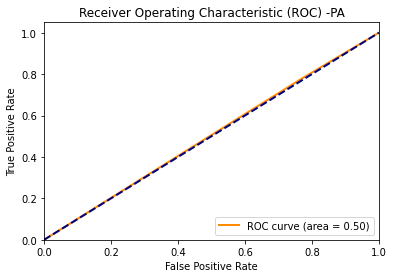

In [16]:
pa_accuracy, pa_precision, pa_recall, pa_fscore = PA_classifier.pa_metrics(pa_predictions, y_test)
PA_classifier.pa_confusion_matrix_plot(pa_predictions, y_test)
PA_classifier.pa_roc_plot(pa_predictions, y_test)

## 3-XGBoost

In [17]:
params = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class classification
    'eval_metric': 'logloss',  # or other appropriate evaluation metric
    'eta': 0.1,  # learning rate
    'max_depth': 15,  # maximum depth of a tree
    'subsample': 0.2,  # subsample ratio of the training instances
    'colsample_bytree': 1  # subsample ratio of columns when constructing each tree
}
    
    
xgb_predictions, xgb_train_valid_predictions, xgb_scores, xgb_train_scores = XGBoost_classifier.train_xgboost(X_train_t_v,y_train_valid,
                                                                                X_test_t_v,y_test,
                                                                               params, 500,0.45)

Execution time of XGBoost: 10.22 seconds


XGBoost - accuracy: 0.5422257300710339
XGBoost - Precision: 0.5665829145728644
XGBoost - Recall: 0.6574344023323615
XGBoost - F-score: 0.6086369770580297


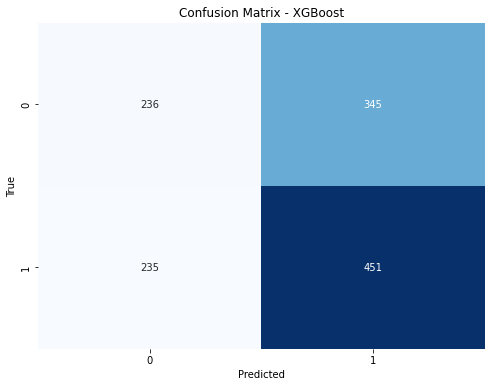

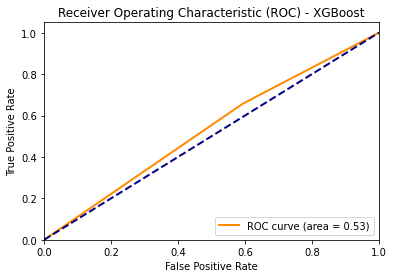

In [20]:
xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore = XGBoost_classifier.xgb_metrics(xgb_predictions, y_test)
XGBoost_classifier.xgb_confusion_matrix_plot(xgb_predictions, y_test)
XGBoost_classifier.xgb_roc_plot(xgb_predictions, y_test)

## 4-LSTM

In [22]:
lstm_model, lstm_history = LSTM_classifier.train_lstm(vocab_size,
                                                      embedding_matrix,
                                                      X_train_t_v,
                                                      y_train_t_v,
                                                      epoches=10,
                                                      batch_size=128,
                                                      MAX_SEQUENCE_LENGTH=300,EMBEDDING_DIM=1500)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 300, 1500)         14271000  
                                                                 
 lstm_layer1 (LSTM)          (None, 300, 128)          834048    
                                                                 
 lstm_layer2 (LSTM)          (None, 300, 64)           49408     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                3250      
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                        

In [23]:
lstm_train_valid_predictions, lstm_predictions, lstm_train_scores, lstm_scores = LSTM_classifier.predict_lstm(lstm_model,
                                                                              X_train_t_v,
                                                                              X_test_t_v,
                                                                             0.4)

361/361 [==============================] - 134s 370ms/step


LSTM - Accuracy: 0.5982636148382005
LSTM - Precision: 0.5814167433302668
LSTM - Recall: 0.9212827988338192
LSTM - F-score: 0.7129159616469262


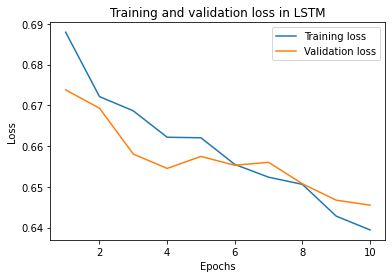

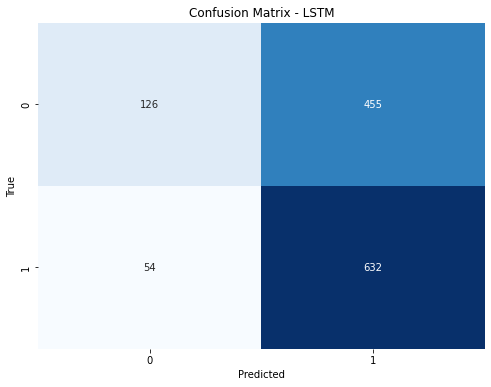

In [24]:
lstm_accuracy, lstm_precision, lstm_recall, lstm_fscore = LSTM_classifier.lstm_metrics(lstm_predictions, y_test_t_v)
LSTM_classifier.lstm_loss_plot(lstm_history)
LSTM_classifier.lstm_confusion_matrix_plot(lstm_predictions, y_test_t_v)

In [26]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import time

def train_lstm_3(vocab_size, embedding_matrix, X_train, y_train, epoches=10,batch_size=128,MAX_SEQUENCE_LENGTH=300,EMBEDDING_DIM=150):
    start_time = time.time()
    
    model = Sequential()
    model.add(Input(shape=(MAX_SEQUENCE_LENGTH,)))
    model.add(Embedding(vocab_size, EMBEDDING_DIM, weights = [embedding_matrix],
                        input_length = MAX_SEQUENCE_LENGTH, trainable=False, name = 'embeddings'))
    model.add(LSTM(256, return_sequences=True,name='lstm_layer1'))
    model.add(LSTM(128, return_sequences=True,name='lstm_layer2'))
    model.add(Dropout(0.1))
    model.add(LSTM(64, return_sequences=True,name='lstm_layer3'))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.1))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

    model.summary()
    
    history = model.fit(X_train, y_train, epochs = epoches, batch_size=batch_size, validation_split=0.2)

    end_time = time.time()
    execution_time = end_time - start_time
    print("Execution time of LSTM: {:.2f} seconds".format(execution_time))

    return model, history

lstm_model3, lstm_history3 = train_lstm_3(vocab_size,
                                                      embedding_matrix,
                                                      X_train_t_v,
                                                      y_train_t_v,
                                                      epoches=9,
                                                      batch_size=128,
                                                      MAX_SEQUENCE_LENGTH=300,EMBEDDING_DIM=1500)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 300, 1500)         14271000  
                                                                 
 lstm_layer1 (LSTM)          (None, 300, 256)          1799168   
                                                                 
 lstm_layer2 (LSTM)          (None, 300, 128)          197120    
                                                                 
 dropout_2 (Dropout)         (None, 300, 128)          0         
                                                                 
 lstm_layer3 (LSTM)          (None, 300, 64)           49408     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                      

In [28]:
lstm_train_valid_predictions3, lstm_predictions3, lstm_train_scores3, lstm_scores3 = LSTM_classifier.predict_lstm(lstm_model3,
                                                                              X_train_t_v,
                                                                              X_test_t_v,
                                                                             0.4)

361/361 [==============================] - 346s 959ms/step


LSTM - Accuracy: 0.5516969218626677
LSTM - Precision: 0.5478896103896104
LSTM - Recall: 0.9839650145772595
LSTM - F-score: 0.7038581856100103


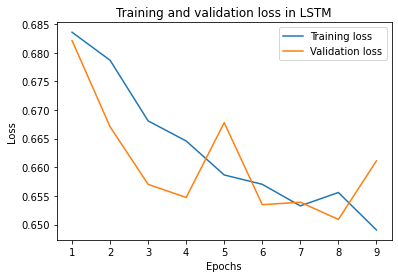

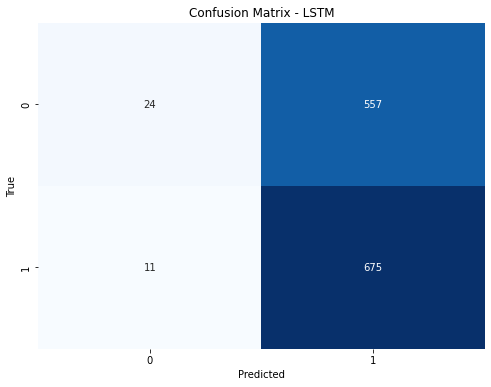

In [29]:
lstm_accuracy3, lstm_precision3, lstm_recall3, lstm_fscore3 = LSTM_classifier.lstm_metrics(lstm_predictions3, y_test_t_v)
LSTM_classifier.lstm_loss_plot(lstm_history3)
LSTM_classifier.lstm_confusion_matrix_plot(lstm_predictions, y_test_t_v)

## 5-BiLSTM

In [236]:
bilstm_model, bilstm_history = BiLSTM_classifier.train_bilstm(vocab_size,
                                                              X_train_t_v,
                                                              y_train_t_v, 3,128,
                                                             ,MAX_SEQUENCE_LENGTH = 300,EMBEDDING_DIM = 1500)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 150)          1427100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 300, 256)         285696    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,881,309
Trainable params: 454,209
Non-

BiLSTM - Accuracy: 0.5485398579321231
BiLSTM - Precision: 0.5456730769230769
BiLSTM - Recall: 0.9927113702623906
BiLSTM - F-score: 0.7042399172699069


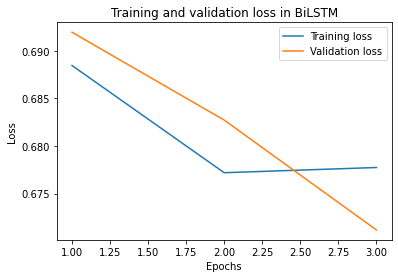

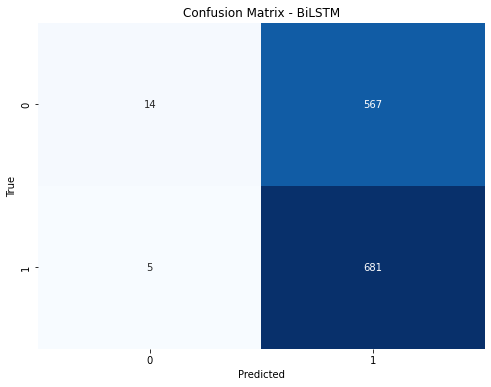

In [239]:
bilstm_train_predictions, bilstm_predictions, bilstm_train_scores,bilstm_scores = BiLSTM_classifier.predict_bilstm(bilstm_model,
                                                                                X_train_t_v, X_test_t_v, 0.4)
bilstm_accuracy, bilstm_precision, bilstm_recall, bilstm_fscore=BiLSTM_classifier.bilstm_metrics(bilstm_predictions, y_test_t_v)
BiLSTM_classifier.bilstm_loss_plot(bilstm_history)
BiLSTM_classifier.bilstm_confusion_matrix_plot(bilstm_predictions, y_test_t_v)
# bilstm_roc_plot(bilstm_predictions, y_test_t_v)

## Evaluate Ensemblely!

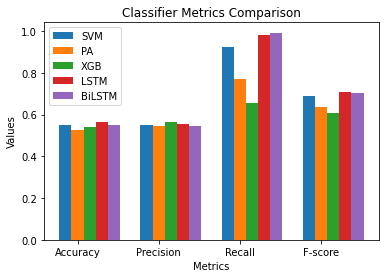

In [240]:
metrics = ['Accuracy','Precision','Recall','F-score'] 
svm = [svm_accuracy, svm_precision, svm_recall, svm_fscore] 
pa=[pa_accuracy, pa_precision, pa_recall, pa_fscore]
xgb=[xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore]
lstm = [lstm_accuracy, lstm_precision, lstm_recall, lstm_fscore] 
bilstm = [bilstm_accuracy, bilstm_precision, bilstm_recall, bilstm_fscore] 

bar_width = 0.15 
index = np.arange(len(metrics))
plt.bar(index, svm, bar_width, label='SVM')
plt.bar(index + bar_width, pa, bar_width, label='PA')
plt.bar(index + 2*bar_width, xgb, bar_width, label='XGB')
plt.bar(index + 3*bar_width, lstm, bar_width, label='LSTM')
plt.bar(index + 4*bar_width, bilstm, bar_width, label='BiLSTM')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Classifier Metrics Comparison')

plt.xticks(index + bar_width, metrics)
plt.legend()
plt.show()
        

In [241]:
import numpy as np
def ensemble_prediction():   
    votes = np.array([list(row) for row in zip(svm_predictions ,xgb_predictions, pa_predictions, lstm_predictions, bilstm_predictions)])
    column_sums = np.sum(votes, axis=1)
    averages_vote = []
    for column_sum in column_sums:
        average = column_sum / 5
        averages_vote.append(average.round())
    return averages_vote

In [242]:
y_pred_ensemble = ensemble_prediction()

accuracy = sum(y_pred_ensemble == y_test) / len(y_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_ensemble, average='binary')
print("Model - accuracy:", accuracy)
print("Model - Precision:", precision)
print("Model - Recall:", recall)
print("Model - F-score:", fscore)

Model - accuracy: 0.5485398579321231
Model - Precision: 0.5462662337662337
Model - Recall: 0.9810495626822158
Model - F-score: 0.7017726798748697


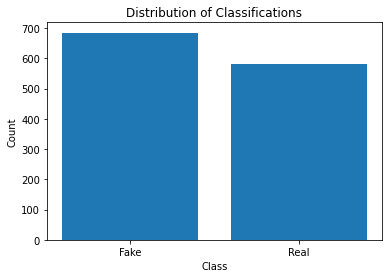

In [46]:
#Visualizing distribution of predeiction of ensemble clas
class_counts = np.bincount(y_pred_ensemble)
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']
plt.xticks(range(len(class_counts)), class_labels)
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## MLP Classifier

In [243]:
#Stack scores
xgb_train_valid_pred_scores = np.array(xgb_train_valid_pred_scores)
xgb_pred_scores= np.array(xgb_pred_scores)

stacked_X_train = np.hstack((X_train_t_v, 
                             svm_train_valid_predictions.reshape((-1, 1)),
                             xgb_train_valid_pred_scores.reshape((-1, 1)),
                             lstm_train_scores.reshape((-1, 1)),
                             bilstm_train_scores.reshape((-1, 1)),
                             pa_train_valid_scores.reshape((-1, 1))))
stacked_X_test = np.hstack((X_test_t_v, 
                            svm_predictions.reshape((-1, 1)),
                            xgb_pred_scores.reshape((-1, 1)),
                            lstm_scores.reshape((-1, 1)),
                            bilstm_scores.reshape((-1, 1)),
                            pa_scores.reshape((-1, 1))))


In [260]:
#Stack Binary
bilstm_predictions = (bilstm_scores > 0.4).astype(int).flatten()
bilstm_train_predictions = (bilstm_train_scores > 0.4).astype(int).flatten()

lstm_predictions = (lstm_scores > 0.4).astype(int).flatten()
lstm_train_predictions = (lstm_train_scores > 0.4).astype(int).flatten()

xgb_predictions = [1 if p >= 0.45 else 0 for p in xgb_pred_scores]
xgb_train_predictions = [1 if p >= 0.45 else 0 for p in xgb_train_valid_pred_scores]

xgb_train_predictions = np.array(xgb_train_predictions)
xgb_predictions= np.array(xgb_predictions)

stacked_X_train = np.hstack((X_train_t_v, 
#                              svm_train_valid_predictions.reshape((-1, 1)),
                             xgb_train_predictions.reshape((-1, 1)),
                             lstm_train_predictions.reshape((-1, 1)),
                             bilstm_train_predictions.reshape((-1, 1)),
#                              pa_train_valid_scores.reshape((-1, 1))
                            ))
stacked_X_test = np.hstack((X_test_t_v, 
#                             svm_predictions.reshape((-1, 1)),
                            xgb_predictions.reshape((-1, 1)),
                            lstm_predictions.reshape((-1, 1)),
                            bilstm_predictions.reshape((-1, 1)),
#                             pa_scores.reshape((-1, 1))
                           ))

In [261]:
mlp_predictions = MLP_classifier.build_mlp(stacked_X_train, y_train_valid,stacked_X_test)

Execution time of MLP: 22.84 seconds


In [262]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
f_score = f1_score(y_test, mlp_predictions, average='micro')
accuracy = accuracy_score(y_test, mlp_predictions)
print(classification_report(y_test, mlp_predictions))
print("MLP F-score:", f_score)
print("MLP Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.49      0.37      0.42       581
           1       0.56      0.67      0.61       686

    accuracy                           0.53      1267
   macro avg       0.52      0.52      0.51      1267
weighted avg       0.52      0.53      0.52      1267

MLP F-score: 0.5311760063141279
MLP Accuracy: 0.5311760063141279


In [ ]:
MLP_classifier.mlp_metrics(mlp_predictions, y_test)